In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score

from imblearn.over_sampling import RandomOverSampler

# Contents

1. Exploring Data

2. Data preprocessing
* Data Cleaning
* Tokenization
* Removal of stopwords
* Stemming

4. Vectorisation using TF-IDF

3. Model Building: 4 Models used:
* Naive Bayes
* Random Forest
* KNeighbors
* SVM


4. Model Evaluation
* Classification Reports
* Evaluation Metrics

In [ ]:
#Dataset
data=pd.read_csv("/content/spam.csv", encoding="latin-1")
data

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


# **Exploring Data**

In [ ]:
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [ ]:
#Drop irrelevant columns and rename columns
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1, inplace=True)
data.rename(columns={'v1':'Target','v2':'Text'}, inplace=True)

In [ ]:
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.groupby("Target").describe()

Text                                                               
       count unique                                                top freq
Target                                                                     
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

<ipython-input-7-7f2a1d3245a2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  fg=sns.countplot(x=data["Target"], palette=cols)


Text(0, 0.5, 'Count')

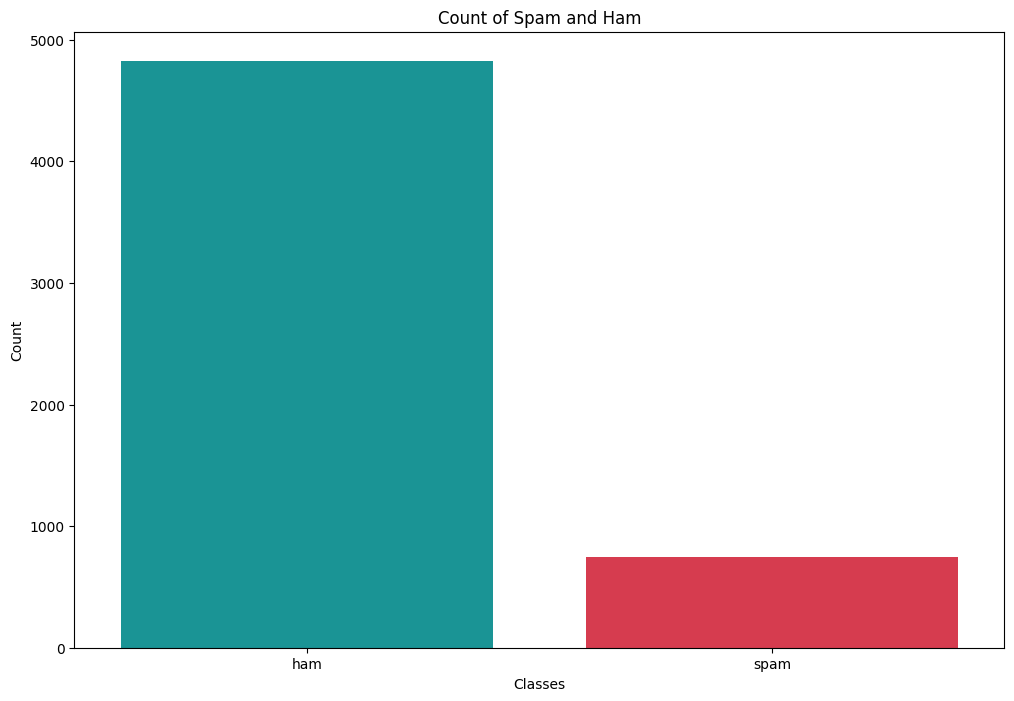

In [ ]:
#palette
cols=["#05A8AA","#EF233C"]
plt.figure(figsize=(12,8))
fg=sns.countplot(x=data["Target"], palette=cols)
fg.set_title("Count of Spam and Ham")
fg.set_xlabel("Classes")
fg.set_ylabel("Count")

In [ ]:
data["Text_Length"]=data["Text"].apply(len)

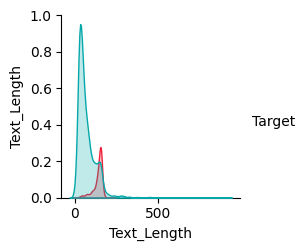

In [ ]:
sns.pairplot(data=data,hue='Target', palette=cols)

<Axes: ylabel='Text_Length'>

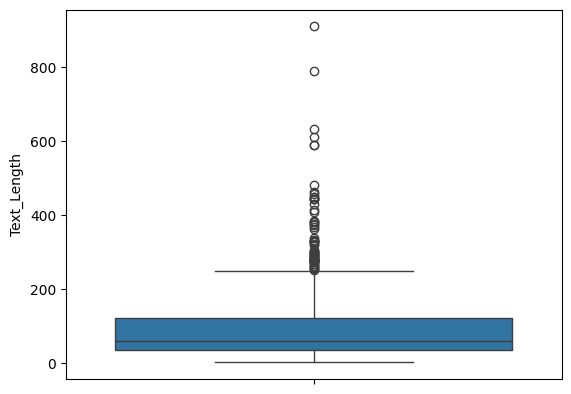

In [ ]:
sns.boxplot(data["Text_Length"])

In [ ]:
print(data[data["Text_Length"]>450].count())

Target         9
Text           9
Text_Length    9
dtype: int64


In [ ]:
#remove outliers
data=data[data["Text_Length"]<450]

# **Data Preprocessing**
**1. Data Cleaning**
* Extract only the alphabetic characters(to remove punctuation and numbers)
* Convert all the characters into lowercase.

In [ ]:
print(data["Text"][:10])

0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
2    Free entry in 2 a wkly comp to win FA Cup fina...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
5    FreeMsg Hey there darling it's been 3 week's n...
6    Even my brother is not like to speak with me. ...
7    As per your request 'Melle Melle (Oru Minnamin...
8    WINNER!! As a valued network customer you have...
9    Had your mobile 11 months or more? U R entitle...
Name: Text, dtype: object


In [ ]:
def clean(text):
    sms= re.sub('[^a-zA-Z]', " ", text)
    sms=sms.lower()

    #remove extra whitespaces
    sms= sms.split()
    sms= ' '.join(sms)
    return sms

data["Cleaned_text"]=data["Text"].apply(clean)

<ipython-input-14-f1caaa38d271>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Cleaned_text"]=data["Text"].apply(clean)


In [ ]:
print(data["Cleaned_text"][:10])

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
2    free entry in a wkly comp to win fa cup final ...
3          u dun say so early hor u c already then say
4    nah i don t think he goes to usf he lives arou...
5    freemsg hey there darling it s been week s now...
6    even my brother is not like to speak with me t...
7    as per your request melle melle oru minnaminun...
8    winner as a valued network customer you have b...
9    had your mobile months or more u r entitled to...
Name: Cleaned_text, dtype: object




**2. Tokenization**

Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.

In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import nltk

In [ ]:
data["Tokenized_text"]=data.apply(lambda row: nltk.word_tokenize(row["Cleaned_text"]), axis=1)

<ipython-input-18-111db300afee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Tokenized_text"]=data.apply(lambda row: nltk.word_tokenize(row["Cleaned_text"]), axis=1)


In [ ]:
print(data["Tokenized_text"][:10])

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
5    [freemsg, hey, there, darling, it, s, been, we...
6    [even, my, brother, is, not, like, to, speak, ...
7    [as, per, your, request, melle, melle, oru, mi...
8    [winner, as, a, valued, network, customer, you...
9    [had, your, mobile, months, or, more, u, r, en...
Name: Tokenized_text, dtype: object


**3. Remove Stopwords**
​

Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
!python -m nltk.downloader stopwords


/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import nltk
nltk.data.path.append("/content/spam.csv")

In [ ]:
def remove_stopwords(text):
    stop_words=set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_text"] = data["Tokenized_text"].apply(remove_stopwords)

<ipython-input-25-fddeaba1599e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Nostopword_text"] = data["Tokenized_text"].apply(remove_stopwords)


In [ ]:
print(data["Nostopword_text"][:10])

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
5    [freemsg, hey, darling, week, word, back, like...
6    [even, brother, like, speak, treat, like, aids...
7    [per, request, melle, melle, oru, minnaminungi...
8    [winner, valued, network, customer, selected, ...
9    [mobile, months, u, r, entitled, update, lates...
Name: Nostopword_text, dtype: object


**4. Stemming**
​

The process of reducing words to their root or base form, typically by removing suffixes or prefixes, with the aim of capturing the core meaning of words.

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stemmer = PorterStemmer()
def stem_word(text):
    stems = [stemmer.stem(word) for word in text]
    return stems
data["Stemmed_text"] = data["Nostopword_text"].apply(stem_word)

<ipython-input-28-99c9459cb7be>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Stemmed_text"] = data["Nostopword_text"].apply(stem_word)


In [ ]:
print(data["Stemmed_text"][:10])

0    [go, jurong, point, crazi, avail, bugi, n, gre...
1                         [ok, lar, joke, wif, u, oni]
2    [free, entri, wkli, comp, win, fa, cup, final,...
3        [u, dun, say, earli, hor, u, c, alreadi, say]
4         [nah, think, goe, usf, live, around, though]
5    [freemsg, hey, darl, week, word, back, like, f...
6    [even, brother, like, speak, treat, like, aid,...
7    [per, request, mell, mell, oru, minnaminungint...
8    [winner, valu, network, custom, select, receiv...
9    [mobil, month, u, r, entitl, updat, latest, co...
Name: Stemmed_text, dtype: object


# Vectorization

TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

Steps in the Vectorizing:
* Creating a corpus of lemmatized text
* Converting the corpus in vector form
* Label Encoding the classes in Target

In [ ]:
corpus= []
for i in data["Stemmed_text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)

corpus[:5]

['go jurong point crazi avail bugi n great world la e buffet cine got amor wat',
 'ok lar joke wif u oni',
 'free entri wkli comp win fa cup final tkt st may text fa receiv entri question std txt rate c appli',
 'u dun say earli hor u c alreadi say',
 'nah think goe usf live around though']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
X.dtype

dtype('float64')

In [ ]:
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

<ipython-input-32-59a2dfe6efb4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Target"] = label_encoder.fit_transform(data["Target"])


# Class Imbalance Handling

To perform oversampling, undersampling, or other balancing techniques to address class imbalance.

In [ ]:
y = data["Target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

In [ ]:
oversampler=RandomOverSampler(random_state=11)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

<ipython-input-35-fa5d589ea11d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Target', data=resampled_df, palette=cols)


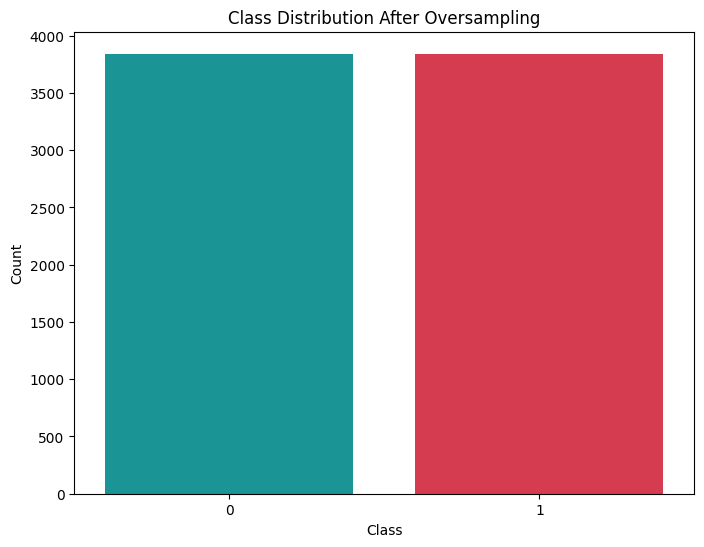

In [ ]:
resampled_df = pd.DataFrame({'Target': y_train})

plt.figure(figsize=(8, 6))
sns.countplot(x='Target', data=resampled_df, palette=cols)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# **Model Building**

In [ ]:
classifiers = [MultinomialNB(),
               RandomForestClassifier(),
               KNeighborsClassifier(),
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.980740 
RandomForest: 0.999479 
KNeighbours: 0.986728 
SVC: 0.999740 


# Model Evaluation

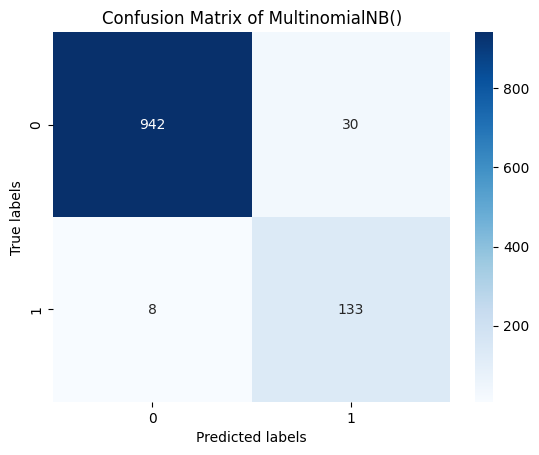

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       972
           1       0.82      0.94      0.87       141

    accuracy                           0.97      1113
   macro avg       0.90      0.96      0.93      1113
weighted avg       0.97      0.97      0.97      1113



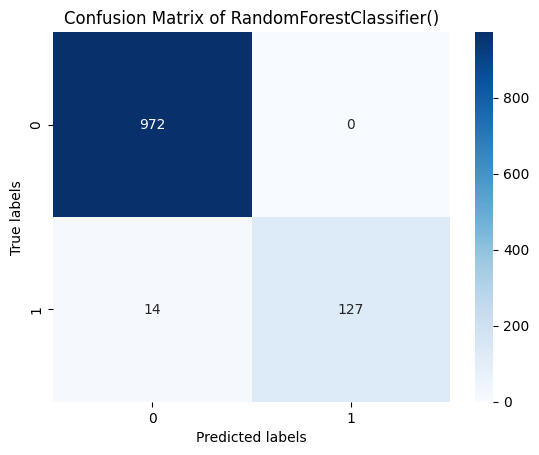

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       972
           1       1.00      0.90      0.95       141

    accuracy                           0.99      1113
   macro avg       0.99      0.95      0.97      1113
weighted avg       0.99      0.99      0.99      1113



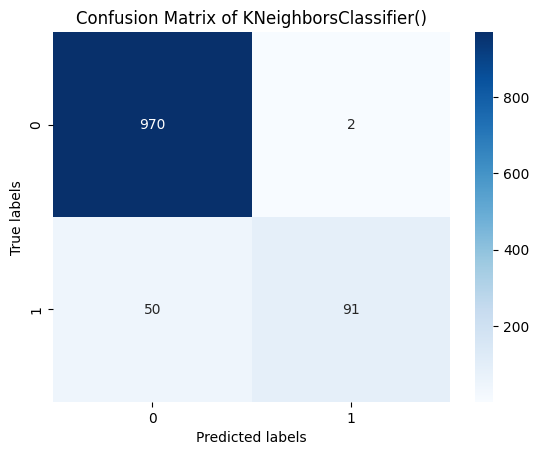

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.98      0.65      0.78       141

    accuracy                           0.95      1113
   macro avg       0.96      0.82      0.88      1113
weighted avg       0.95      0.95      0.95      1113



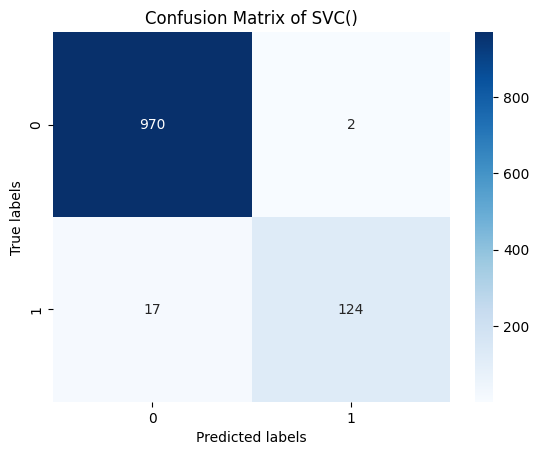

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       972
           1       0.98      0.88      0.93       141

    accuracy                           0.98      1113
   macro avg       0.98      0.94      0.96      1113
weighted avg       0.98      0.98      0.98      1113



In [ ]:
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sensitivity_list = []
specificity_list = []
fpr_list = []
fnr_list = []
npv_list = []
fdr_list = []
mcc_list = []

for cls in classifiers:

    y_pred = cls.predict(X_test)

    # Confusion Matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix of {cls}')
    plt.show()


    print(classification_report(y_test, y_pred))


    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (fn + tp)
    f1 = 2 * (precision * recall) / (precision + recall)
    sensitivity = tp / (fn + tp)
    specificity = tn / (tn + fp)
    fpr = fp / (tn + fp)
    fnr = fn / (fn + tp)
    npv = tn / (tn + fn)
    fdr = fp / (fp + tp)
    mcc = (tp * tn - fp * fn) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5


    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    fpr_list.append(fpr)
    fnr_list.append(fnr)
    npv_list.append(npv)
    fdr_list.append(fdr)
    mcc_list.append(mcc)

metrics_df = pd.DataFrame({
    'Model': [pipe_dict[i] for i in range(len(pipe_dict))],
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Measure': f1_list,
    'Sensitivity': sensitivity_list,
    'Specificity': specificity_list,
    'FPR': fpr_list,
    'FNR': fnr_list,
    'NPV': npv_list,
    'FDR': fdr_list,
    'MCC': mcc_list
})


In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [ ]:

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [ ]:
nRowsRead = 1000
# specify 'None' if want to read whole file
# spam.csv has 5572 rows in reality, but we are only loading/previewing the first 1000 rows
#Dataset
data=pd.read_csv("/content/spam.csv", encoding="latin-1")
data.dataframeName = 'spam.csv'
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 5572 rows and 5 columns


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nCol = df.shape[1]
    nGraphRow = int(round(nCol / nGraphPerRow))
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts = pd.DataFrame({'value': valueCounts.index, 'count': valueCounts.values})
            valueCounts.plot.bar(x = 'value', y='count')
        else:
            columnDf.hist(bins = 30)
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'Distribution of {df.columns[i]}')
    plt.tight_layout(pad = 1.0)
    plt.show()

In [ ]:
# Checking for null values
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5126
Unnamed: 3    5159
Unnamed: 4    5164
dtype: int64

In [ ]:
# Checking for null values
data.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [ ]:
# Checking Duplicate values
data.duplicated().sum()


403

In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
